In [39]:
# imports we need + utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

bold_start = "\033[1m"
bold_end = "\033[0m"

**Global Variables for metrics**

In [40]:
# Global data for metrics
metrics_dict_val = {
    'XGBoost': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0},
    'Logistic Regression': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0},
    'Random Forest': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
}

metrics_dict_test = {
    'XGBoost': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0},
    'Logistic Regression': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0},
    'Random Forest': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
}

In [41]:
# Exploratory Data Analysis code cell
data = pd.read_csv("resources/lending_club_loan_two.csv")


def plot_3_row_histogram(df):
    numerics_df = df.select_dtypes(include=['number'])
    print("Number of numeric cols: ", len(numerics_df.columns), " of ", len(df.columns))
    n_rows = len(numerics_df.columns) // 3
    n_rows += len(numerics_df.columns) % 3

    # Create a figure and axes with matplotlib's subplots()
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))

    for idx, col in enumerate(numerics_df.columns):
        i = idx // 3
        j = idx % 3

        sns.histplot(numerics_df[col], ax=axs[i][j], kde=True)
        axs[i][j].set_title(f"Distribution of {col}")

    # Remove empty subplots
    if len(numerics_df.columns) % 3:
        for j in range(len(numerics_df.columns) % 3, 3):
            fig.delaxes(axs[i][j])

    plt.tight_layout()
    plt.show()


def plot_label_distribution(df, label):
    values = df[label].value_counts()
    values.plot(kind='bar', figsize=(5, 3))
    plt.title('Label values distribution')
    plt.show()


def plot_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=['number'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


def percentage_of_missing_values(df):
    missing_columns = df.columns[data.isna().any()].to_list()
    missing_values = df[missing_columns].isna().mean() * 100
    missing_values = missing_values.apply(lambda x: f'{x: .2f}%')

    missing_df = pd.DataFrame({'Missing %': missing_values})
    print("Percentage of missing values")
    display(missing_df)


def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = df[z_scores > threshold].index
    return outliers


def show_outliers(df):
    outlier_data = []
    numerics_df = df.select_dtypes(include=['number'])
    for col in numerics_df.columns:
        ol = detect_outliers_zscore(numerics_df, col)
        outlier_data.append({'Column': col, 'Outlier Count': len(ol)})
    outliers_df = pd.DataFrame(outlier_data)
    print("Outliers found in each feature")
    display(outliers_df.sort_values(by='Outlier Count', ascending=False))


def show_unique_values_categorical_features(df):
    categorical_cols = data.select_dtypes(include=['object'])
    unique_categories = []
    for col in categorical_cols.columns:
        unique_categories.append({'Column': col, 'Unique Count': data[col].nunique()})
    unique_categories_df = pd.DataFrame(unique_categories)
    print("Count of unique values in categorical features")
    display(unique_categories_df.sort_values(by='Unique Count', ascending=False))


def feature_importance_random_forest(x, y):
    # Train a Random Forest model
    rf = RandomForestClassifier()
    rf.fit(x, y)

    # Get feature importance
    importance = rf.feature_importances_

    # Create a DataFrame to visualize importance
    feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    display(feature_importance)


def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1


def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


def eda():
    #label distribution
    plot_label_distribution(data, 'loan_status')

    # feature distribution
    plot_3_row_histogram(data)

    #correlation matrix
    plot_correlation_matrix(data)

    # missing values
    percentage_of_missing_values(data)

    # outliers
    show_outliers(data)

    # show unique values for each categorical feature
    show_unique_values_categorical_features(data)


# Exploratory Data Exploration

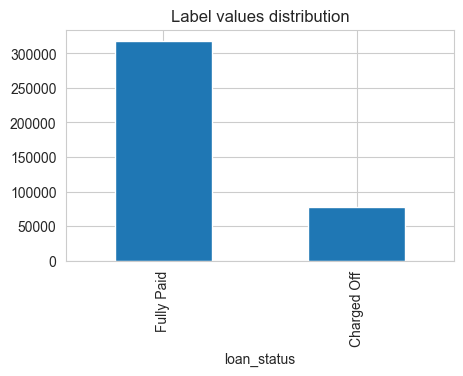

Number of numeric cols:  12  of  27


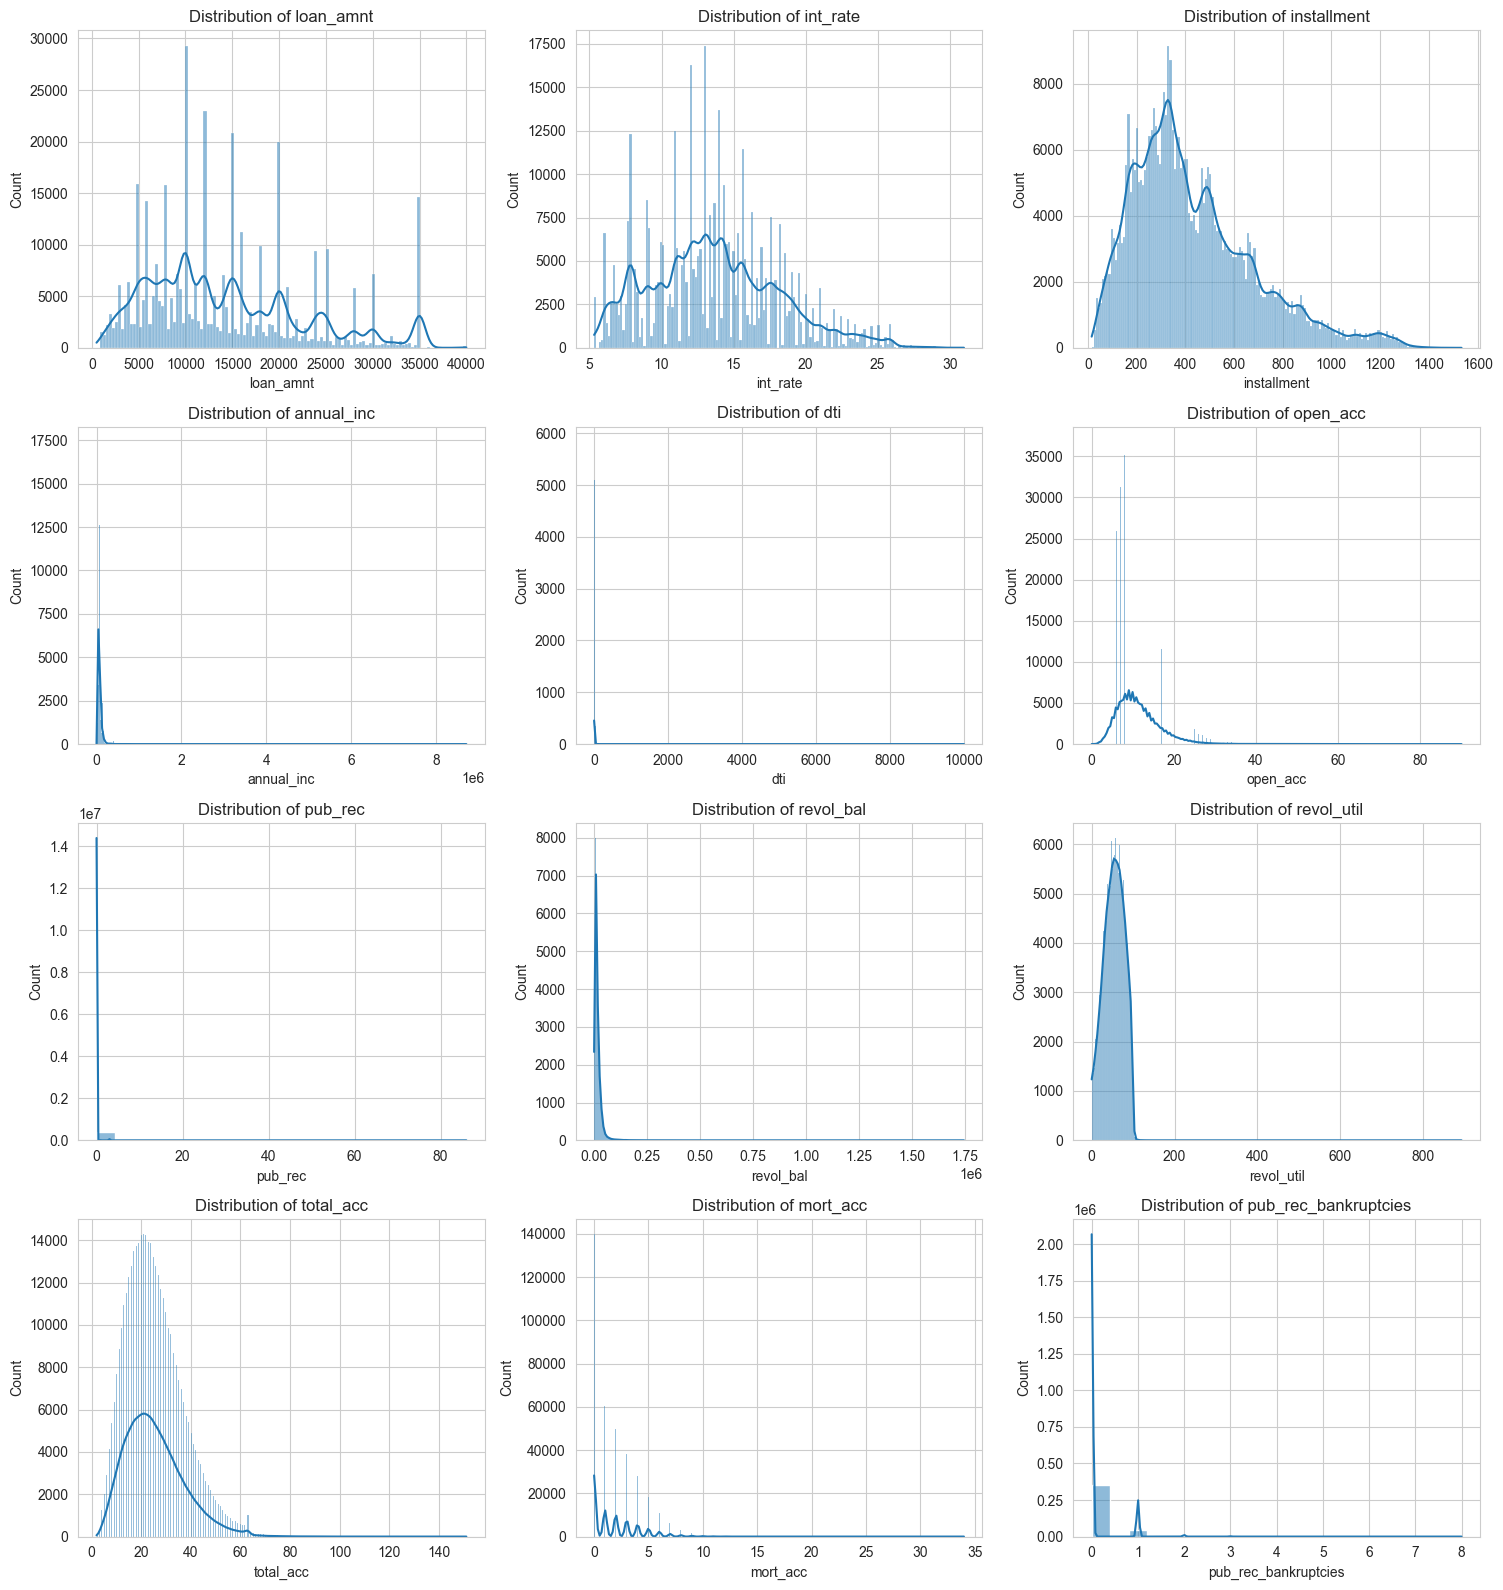

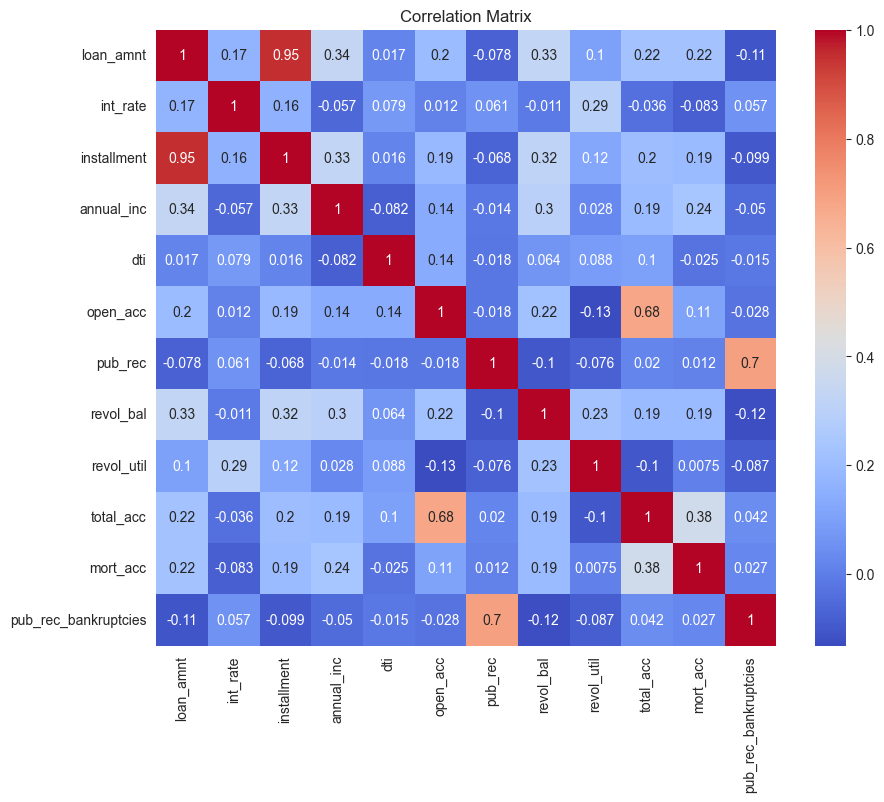

Percentage of missing values


,Missing %
emp_title,5.79%
emp_length,4.62%
title,0.44%
revol_util,0.07%
mort_acc,9.54%
pub_rec_bankruptcies,0.14%


Outliers found in each feature


,Column,Outlier Count
6,pub_rec,8019
2,installment,5050
5,open_acc,4879
7,revol_bal,4790
10,mort_acc,3722
9,total_acc,3401
3,annual_inc,3197
11,pub_rec_bankruptcies,2325
1,int_rate,756
0,loan_amnt,185


Count of unique values in categorical features


,Column,Unique Count
14,address,393700
3,emp_title,173105
10,title,48816
11,earliest_cr_line,684
7,issue_d,115
2,sub_grade,35
9,purpose,14
4,emp_length,11
1,grade,7
5,home_ownership,6


In [42]:
# call exploratory data analysis methods
eda()

## EDA Observations

## Distributions:
#### Right Skewed: 
* *loan_amnt*, *int_rate*, *installment*, *annual_inc*, *dti*, *open_acc*, *pub_rec*, *revol_bal*, *total_acc* 
* These variables have a long tail on the right, indicating a concentration of values at the lower end with a few very high values.

#### Approximately Normal: 
* *revol_util*
* This distribution resembles a bell curve, suggesting a symmetric distribution of values around the mean.

#### Highly Imbalanced: 
* `mort_acc, pub_rec_bankruptcies` 
* These variables have a very uneven distribution, with a large majority of values concentrated in a single category.

### Preprocessing Strategies:
1. Addressing the Imbalance in label instances:
    - Oversampling using SMOTE and ADASYN: From the bar graph above relating to Fully Paid vs Charged-Off, we can see a significant imbalance in label instance that need to be addressed.
    - We're using both Synthetic Minority Sampling and Adaptive Synthetic Sampling to experiment and cross-validate which is better since SMOTE might not perform well with complex distributions
2. Handling Skewness:
    - We chose to cap the extreme values at a certain percentile to reduce the impact of these outliers without removing them entirely. 
3. Normalization/Standardization:
    - We shall standardize `revol_util` since it's close to normal distribution. This will help improve model performance.
    - All other variables to are going to be normalized using min-max scaling to rescale them to a range between 0 and 1. This will prevent features with larger variations from biasing the models we train later on.
4. Because `pub_rec, mort_acc, pub_rec_bankruptcies` are heavily right-skewed and have most of their values as 0, we're choosing to simplify them into binary e.g. 0 - no mort_acc, 1 - has mort_acc  
5. Address feature needs to be augmented/engineered into zip_code because there are too many variations for it to be encoded effeciently.

# Data Preprocessing

The goal here is to do the following:

* Impute missing values
* Remove repeating and irrelevant features
* Encode categorical features into numerical format
* Oversample the minority class to increase its number of instances
* Change some features into variations of themselves (feature engineer)

In [43]:
# Convert features to simple binary 
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)
data['loan_status'] = data.loan_status.map({'Fully Paid': 1, 'Charged Off': 0})

# one-hot encode categories we found as categorical
one_hot_encode_cols = ['verification_status',  'initial_list_status',
                       'application_type']
data = pd.get_dummies(data, columns=one_hot_encode_cols, drop_first=True)

# the shape of the data
print(f"The shape of the dataset (instances, features): {data.shape}")

The shape of the dataset (instances, features): (396030, 29)


### 2.2 Converting categorical string features into numerical formats

In [44]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [45]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [46]:
data.term.unique()

array([36, 60])

In [47]:
data.drop('grade', axis=1, inplace=True)

address
We are going to feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column.

In [48]:
data.address.head()

0       0174 Michelle Gateway\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3              823 Reid Ford\nDelacruzside, MA 00813
4               679 Luna Roads\nGreggshire, VA 11650
Name: address, dtype: object

In [49]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [50]:
data.zip_code.value_counts()

zip_code
70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: count, dtype: int64

In [51]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the zip_code column
data['zip_code_encoded'] = label_encoder.fit_transform(data['zip_code'])

label_encoder = LabelEncoder()
data['home_ownership_encoded'] = label_encoder.fit_transform(data['home_ownership'])

label_encoder = LabelEncoder()
data['purpose_encoded'] = label_encoder.fit_transform(data['purpose'])

data.drop('zip_code', axis=1, inplace=True)
data.drop('purpose', axis=1, inplace=True)
data.drop('home_ownership', axis=1, inplace=True)

data.drop('address', axis=1, inplace=True)

sub_grade_mapping = {
    'A1': 35, 'A2': 34, 'A3': 33, 'A4': 32, 'A5': 31,
    'B1': 30, 'B2': 29, 'B3': 28, 'B4': 27, 'B5': 26,
    'C1': 25, 'C2': 24, 'C3': 23, 'C4': 22, 'C5': 21,
    'D1': 20, 'D2': 19, 'D3': 18, 'D4': 17, 'D5': 16,
    'E1': 15, 'E2': 14, 'E3': 13, 'E4': 12, 'E5': 11,
    'F1': 10, 'F2': 9, 'F3': 8, 'F4': 7, 'F5': 6,
    'G1': 5, 'G2': 4, 'G3': 3, 'G4': 2, 'G5': 1
}
data['sub_grade_encoded'] = data['sub_grade'].map(sub_grade_mapping)
data.drop('sub_grade', axis=1, inplace=True)


Removing `issue_d` feature
This would be data leakage because we would not know the loan issue date beforehand when using our model/in our usecase. Therefore choosing to drop this feature.

In [52]:
data.drop('issue_d', axis=1, inplace=True)

In [53]:
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda x: datetime.strptime(x, "%b-%Y").year)

In [54]:
data.earliest_cr_line.nunique()

65

In [55]:
data.earliest_cr_line.value_counts()

earliest_cr_line
2000    29366
2001    29083
1999    26491
2002    25901
2003    23657
        ...  
1951        3
1950        3
1953        2
1944        1
1948        1
Name: count, Length: 65, dtype: int64

### Removing or Imputing missing values

In [56]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data[column].shape[0]) * 100
        print(
            f"{bold_start}'{column}'{bold_end}: number of missing values: {bold_start}'{missing}'{bold_end} ==> {bold_start}'{portion:.3f}%'{bold_end}")

'emp_title': number of missing values: '22927' ==> '5.789%'
'emp_length': number of missing values: '18301' ==> '4.621%'
'title': number of missing values: '1756' ==> '0.443%'
'revol_util': number of missing values: '276' ==> '0.070%'
'mort_acc': number of missing values: '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values: '535' ==> '0.135%'


In [57]:
data['emp_title'].nunique()

173105

The **emp_title** has too many unique values to encode and dataset will not be sufficent if used with it. So, the best thing to do is drop it.

In [58]:
data.drop('emp_title', axis=1, inplace=True)

Now, let's look at **emp_length**

In [59]:
data["emp_length"].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [60]:
for year in data["emp_length"].unique():
    print(f"{year} years in the positions:")
    print(f"{bold_start}{year}{bold_end} years in the positions:")
    print("\n=============================================\n")

10+ years years in the positions:
10+ years years in the positions:


4 years years in the positions:
4 years years in the positions:


< 1 year years in the positions:
< 1 year years in the positions:


6 years years in the positions:
6 years years in the positions:


9 years years in the positions:
9 years years in the positions:


2 years years in the positions:
2 years years in the positions:


3 years years in the positions:
3 years years in the positions:


8 years years in the positions:
8 years years in the positions:


7 years years in the positions:
7 years years in the positions:


5 years years in the positions:
5 years years in the positions:


1 year years in the positions:
1 year years in the positions:


nan years in the positions:
nan years in the positions:



**Charge offs** seem to be extremely similar across all **emp_length**. So, we are going to drop it.

In [61]:
data.drop('emp_length', axis=1, inplace=True)

Now, let's have a look at **title**.

In [62]:
data.title.value_counts().head()

title
Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Name: count, dtype: int64

In [63]:
data.title.unique().shape

(48817,)

In [64]:
data.drop("title", axis=1, inplace=True)

Let's have a look at **mort_acc**.

In [65]:
data.mort_acc.value_counts()

mort_acc
1.00    218458
0.00    139777
Name: count, dtype: int64

In [66]:
data.mort_acc.isna().sum()

37795

Imputing **mort_acc** should be imputed using either mean or prediction model, for this purpose we will do using **Random Forest**

In [67]:
# Split the data into two parts: one with missing values and one without
missing_data = data[data['mort_acc'].isnull()]
complete_data = data.dropna(subset=['mort_acc'])

# Select features and target variable
X = complete_data.drop(columns=['mort_acc'])
y = complete_data['mort_acc']

# Split the complete data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict missing values
imputed_values = model.predict(missing_data.drop(columns=['mort_acc']))

# Impute missing values in the mort_acc column
data.loc[data['mort_acc'].isnull(), 'mort_acc'] = imputed_values

In [68]:
data.mort_acc.value_counts()

mort_acc
1.00    237861
0.00    158169
Name: count, dtype: int64

In [69]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

# drop missing value instances that are less than 0.2% of the dataset
data.dropna(inplace=True)
display(data.shape)
data.loan_status.value_counts()

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


(395219, 24)

loan_status
1    317696
0     77523
Name: count, dtype: int64

Removing `revol_util & pub_rec_bankruptcies` missing values instances
These two features have missing data points, but they account for less than 0.5% of the total data. So we are going to remove the rows that are missing those values in those columns with dropna().

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395219 entries, 0 to 396029
Data columns (total 24 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   annual_inc                           395219 non-null  float64
 5   loan_status                          395219 non-null  int64  
 6   dti                                  395219 non-null  float64
 7   earliest_cr_line                     395219 non-null  int64  
 8   open_acc                             395219 non-null  float64
 9   pub_rec                              395219 non-null  int64  
 10  revol_bal                            395219 non-null  float64
 11  revol_util        

## Preparing the Test data

### Checking distribution of data

In [71]:
# Define a threshold for Z-score
threshold = 3

# Create a copy of the data to avoid modifying the original DataFrame
data_clean = data.copy()

# Dictionary to store counts of outliers for each column
outliers_count_dict = {}

# Loop through each numerical column in the DataFrame
for column in data_clean.select_dtypes(include=[np.number]).columns:
    # Calculate Z-scores
    z_scores = (data_clean[column] - data_clean[column].mean()) / data_clean[column].std()
    # Identify outliers
    outliers = np.abs(z_scores) > threshold
    # Store the count of previous outliers
    outliers_count_dict[column] = outliers.sum()
    # Calculate the mean value of the column
    mean_value = data_clean[column].mean()
    # If the column is of type int64, cast the mean value to int
    if pd.api.types.is_integer_dtype(data_clean[column]):
        mean_value = int(mean_value)
    # Replace outliers with the mean value of the column
    data_clean.loc[outliers, column] = mean_value

# Print the shape of the original and cleaned data
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {data_clean.shape}")

# Print count of previous outliers
print("\nCount of previous outliers in each column:")
for column, count in outliers_count_dict.items():
    print(f"Column: {column} - Outliers: {count}")

# Optional: Check if there are any remaining outliers
remaining_outliers = ((data_clean - data_clean.mean()) / data_clean.std()).abs() > threshold
print("\nRemaining outliers in each column after cleaning:")
print(remaining_outliers.sum())

Original data shape: (395219, 24)
Cleaned data shape: (395219, 24)

Count of previous outliers in each column:
Column: loan_amnt - Outliers: 184
Column: term - Outliers: 0
Column: int_rate - Outliers: 754
Column: installment - Outliers: 5042
Column: annual_inc - Outliers: 3190
Column: loan_status - Outliers: 0
Column: dti - Outliers: 12
Column: earliest_cr_line - Outliers: 4993
Column: open_acc - Outliers: 4873
Column: pub_rec - Outliers: 0
Column: revol_bal - Outliers: 4771
Column: revol_util - Outliers: 16
Column: total_acc - Outliers: 3396
Column: mort_acc - Outliers: 0
Column: pub_rec_bankruptcies - Outliers: 0
Column: zip_code_encoded - Outliers: 0
Column: home_ownership_encoded - Outliers: 0
Column: purpose_encoded - Outliers: 9892
Column: sub_grade_encoded - Outliers: 1988

Remaining outliers in each column after cleaning:
loan_amnt                                  0
term                                       0
int_rate                                  51
installment            

## Oversampling the dataset using SMOTE and ADASYN 

In [72]:
def smote_oversampling(x, y):
    """
    Synthetic Minority Sampling
    :param x: predictors dataframe
    :param y: label dataframe
    :return: x, y dataframes with synthetic instances
    """
    smote = SMOTE(random_state=42)
    # fit and resample the data
    x_resampled, y_resampled = smote.fit_resample(x, y)

    return x_resampled, y_resampled


def adasyn_oversampling(x, y):
    """
    Adaptive Synthetic Sampling
    :param x: predictors dataframe
    :param y: label dataframe
    :return: x, y dataframes with synthetic instances
    """
    adasyn = ADASYN(random_state=42)
    # fit and resample the data
    x_resampled, y_resampled = adasyn.fit_resample(x, y)

    return x_resampled, y_resampled


# Assuming data_clean is your DataFrame and 'target' is the target variable
X = data_clean.drop(columns=['loan_status'])
y = data_clean['loan_status']

# Split the data into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE to the training data
smote_x, smote_y = smote_oversampling(X_train, y_train)
adasyn_x, adasyn_y = adasyn_oversampling(X_train, y_train)


print(f"Original dataset shape: {Counter(y_train)}")
print(f"SMOTE sampled dataset shape: {Counter(smote_y)}")
print(f"ADASYN sampled dataset shape: {Counter(adasyn_y)}")


Original dataset shape: Counter({1: 222387, 0: 54266})
SMOTE sampled dataset shape: Counter({1: 222387, 0: 222387})
ADASYN sampled dataset shape: Counter({1: 222387, 0: 216452})


## Feature Importance Analysis

In [73]:
print("Feature importance on SMOTE dataset")
feature_importance_random_forest(smote_x, smote_y)

print("Feature importance on ADASYN dataset")
feature_importance_random_forest(adasyn_x, adasyn_y)

Feature importance on SMOTE dataset


,Feature,Importance
19,zip_code_encoded,0.23
12,mort_acc,0.08
22,sub_grade_encoded,0.08
1,term,0.07
2,int_rate,0.06
5,dti,0.04
10,revol_util,0.04
4,annual_inc,0.04
20,home_ownership_encoded,0.04
9,revol_bal,0.04


Feature importance on ADASYN dataset


,Feature,Importance
19,zip_code_encoded,0.23
12,mort_acc,0.08
22,sub_grade_encoded,0.07
2,int_rate,0.07
1,term,0.07
5,dti,0.04
10,revol_util,0.04
4,annual_inc,0.04
9,revol_bal,0.04
7,open_acc,0.04


# Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_conf_matrix)
print('Validation Classification Report:')
print(val_class_report)

Validation Accuracy: 0.8146180186562758
Validation Confusion Matrix:
[[ 1775  9931]
 [ 1059 46518]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.15      0.24     11706
           1       0.82      0.98      0.89     47577

    accuracy                           0.81     59283
   macro avg       0.73      0.56      0.57     59283
weighted avg       0.79      0.81      0.77     59283


In [75]:
y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_conf_matrix)
print('Test Classification Report:')
print(test_class_report)


Test Accuracy: 0.8164397888096081
Test Confusion Matrix:
[[ 1785  9766]
 [ 1116 46616]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.15      0.25     11551
           1       0.83      0.98      0.90     47732

    accuracy                           0.82     59283
   macro avg       0.72      0.57      0.57     59283
weighted avg       0.79      0.82      0.77     59283


In [76]:
# Predict on validation set
y_val_pred = model.predict(X_val)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1_score = f1_score(y_val, y_val_pred)

# Fill metrics for validation set
metrics_dict_val['Logistic Regression'] = {'accuracy': val_accuracy, 'precision': val_precision, 'recall': val_recall, 'f1_score': val_f1_score}

# Predict on test set
y_test_pred = model.predict(X_test)

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

# Fill metrics for test set
metrics_dict_test['Logistic Regression'] = {'accuracy': test_accuracy, 'precision': test_precision, 'recall': test_recall, 'f1_score': test_f1_score}

# ANN

In [77]:
# Define the model
input_dim = smote_x.shape[1]
model = Sequential()

model.add(Dense(64, input_shape=(input_dim,)))
model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
model.add(Dense(32))
model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
model.add(Dense(16))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(smote_x, smote_y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))

Epoch 1/10


/Users/andrewtwijukye/.local/share/virtualenvs/MLLabs-HkU2X8db/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11120/11120 ━━━━━━━━━━━━━━━━━━━━ 4s 296us/step - accuracy: 0.5352 - loss: 484.2934 - val_accuracy: 0.0000e+00 - val_loss: 3.2413
Epoch 2/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 302us/step - accuracy: 0.5655 - loss: 0.9385 - val_accuracy: 0.0034 - val_loss: 1.0917
Epoch 3/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 294us/step - accuracy: 0.6015 - loss: 0.7144 - val_accuracy: 0.5274 - val_loss: 0.7673
Epoch 4/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 290us/step - accuracy: 0.6343 - loss: 0.6705 - val_accuracy: 0.4546 - val_loss: 0.7417
Epoch 5/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 295us/step - accuracy: 0.6650 - loss: 0.6279 - val_accuracy: 0.1170 - val_loss: 1.0770
Epoch 6/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 307us/step - accuracy: 0.6791 - loss: 0.6028 - val_accuracy: 0.7807 - val_loss: 0.5171
Epoch 7/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 290us/step - accuracy: 0.6888 - loss: 0.5907 - val_accuracy: 0.1785 - val_loss: 0.8746
Epoch 8/10
11120/11120 ━━━━━━━━━━━━━━━━━━━━ 3s 290us/step - accurac

### XGBoost Classifier

In [78]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(smote_x, label=smote_y)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameter dictionary
params = {
    'objective': 'binary:logistic',  # binary classification
    'max_depth': 10,  # maximum depth of a tree
    'eta': 0.03,  # step size shrinkage
    'eval_metric': 'logloss',  # evaluation metric
    'random_state': 42  # seed for reproducibility
}

# Specify the training and validation sets
evals = [(dtrain, 'train'), (dval, 'eval')]

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10)

# Predict on the test set
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics for validation set
y_val_pred = (bst.predict(dval) > 0.5).astype(int)
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_score_val = f1_score(y_val, y_val_pred)

# Fill metrics for validation set
metrics_dict_val['XGBoost'] = {'accuracy': accuracy_val, 'precision': precision_val, 'recall': recall_val, 'f1_score': f1_score_val}

# Calculate metrics for test set
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)

# Fill metrics for test set
metrics_dict_test['XGBoost'] = {'accuracy': accuracy_test, 'precision': precision_test, 'recall': recall_test, 'f1_score': f1_score_test}

print(classification_report(y_test, y_pred))

[0]	train-logloss:0.67471	eval-logloss:0.67682
[1]	train-logloss:0.65736	eval-logloss:0.66140
[2]	train-logloss:0.64093	eval-logloss:0.64679
[3]	train-logloss:0.62550	eval-logloss:0.63303
[4]	train-logloss:0.61075	eval-logloss:0.61991
[5]	train-logloss:0.59684	eval-logloss:0.60748
[6]	train-logloss:0.58378	eval-logloss:0.59575
[7]	train-logloss:0.57128	eval-logloss:0.58453
[8]	train-logloss:0.55939	eval-logloss:0.57387
[9]	train-logloss:0.54807	eval-logloss:0.56370
[10]	train-logloss:0.53732	eval-logloss:0.55400
[11]	train-logloss:0.52701	eval-logloss:0.54475
[12]	train-logloss:0.51710	eval-logloss:0.53587
[13]	train-logloss:0.50785	eval-logloss:0.52746
[14]	train-logloss:0.49885	eval-logloss:0.51937
[15]	train-logloss:0.49025	eval-logloss:0.51161
[16]	train-logloss:0.48227	eval-logloss:0.50435
[17]	train-logloss:0.47460	eval-logloss:0.49736
[18]	train-logloss:0.46698	eval-logloss:0.49053
[19]	train-logloss:0.45984	eval-logloss:0.48410
[20]	train-logloss:0.45308	eval-logloss:0.47796
[2

# Random Forest Classifier

In [83]:
# output from prev. run
# Best parameters: {'rf__max_depth': 10, 'rf__max_features': 15, 'rf__n_estimators': 200}
# Best F1 score: 0.8958131813728689
def parameter_tuning():
    rf = RandomForestClassifier(
        random_state=42,
        criterion='entropy'
    )

    param_grid = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [5, 10],
        # 'rf__min_samples_split': [10, 30, 50], # since 
        # 'rf__min_samples_leaf': [10, 20, 60],
        'rf__max_features': ['auto', 10, 15],
    }

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', rf)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,  # Use the pipeline as the estimator
        param_grid=param_grid,
        scoring={
            'accuracy': make_scorer(accuracy_score),
            # 'precision': make_scorer(precision_score),
            # 'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score),
            # 'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
        },
        refit='f1',
        cv=5,
        # n_jobs=-1,  # parallelism through using all available cores
        verbose=2
    )

    # Fit the grid search (oversampling happens within each fold)
    grid_search.fit(X_train, y_train)  # using the original (non-smote) training dataset

    # Print best params and performance
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_}")

# hyoer parameter tuning uing grid search
# parameter_tuning()


In [84]:

# RainForest model with tuned/found params
rf = RandomForestClassifier(
    random_state=42,
    criterion='entropy',
    max_depth=10,
    max_features=15,
    n_estimators=200
)

rf.fit(X_train, y_train)

# predict on validation set
y_val_pred = rf.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_score_val = f1_score(y_val, y_val_pred)

# update validation metrics
metrics_dict_val['Random Forest'] = {
    'accuracy': accuracy_val,
    'precision': precision_val,
    'recall': recall_val,
    'f1_score': f1_score_val
}

# Calculate metrics for test set
y_pred = rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)

# Fill metrics for test set
metrics_dict_test['Random Forest'] = {
    'accuracy': accuracy_test,
    'precision': precision_test,
    'recall': recall_test,
    'f1_score': f1_score_test
}


In [86]:

# RainForest model with tuned/found params
rf = RandomForestClassifier(
    random_state=42,
    criterion='entropy',
    max_depth=10,
    max_features=15,
    n_estimators=200
)

rf.fit(smote_x, smote_y)

# predict on validation set
y_val_pred = rf.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_score_val = f1_score(y_val, y_val_pred)

print("Smote validation metrics")
print(f"""
- accuracy_test => {accuracy_test}
- precision_test => {precision_test}
- recall_test => {recall_test}
- f1_score_test => {f1_score_test}
""")

# update validation metrics
# metrics_dict_val['Random Forest'] = {
#     'accuracy': accuracy_val,
#     'precision': precision_val,
#     'recall': recall_val,
#     'f1_score': f1_score_val
# }

# Calculate metrics for test set
y_pred = rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)

print("Smote test metrics")
print(f"""
- accuracy_test => {accuracy_test}
- precision_test => {precision_test}
- recall_test => {recall_test}
- f1_score_test => {f1_score_test}
""")

# Fill metrics for test set
# metrics_dict_test['Random Forest'] = {
#     'accuracy': accuracy_test,
#     'precision': precision_test,
#     'recall': recall_test,
#     'f1_score': f1_score_test
# }


Smote validation metrics

- accuracy_test => 0.8910311556432704
- precision_test => 0.8822189294313761
- recall_test => 0.997884019106679
- f1_score_test => 0.9364935805430487
Smote test metrics

- accuracy_test => 0.8658300018555066
- precision_test => 0.8943100713719271
- recall_test => 0.9450473476912763
- f1_score_test => 0.9189789349305301


## 6. Evaluation of Metrics

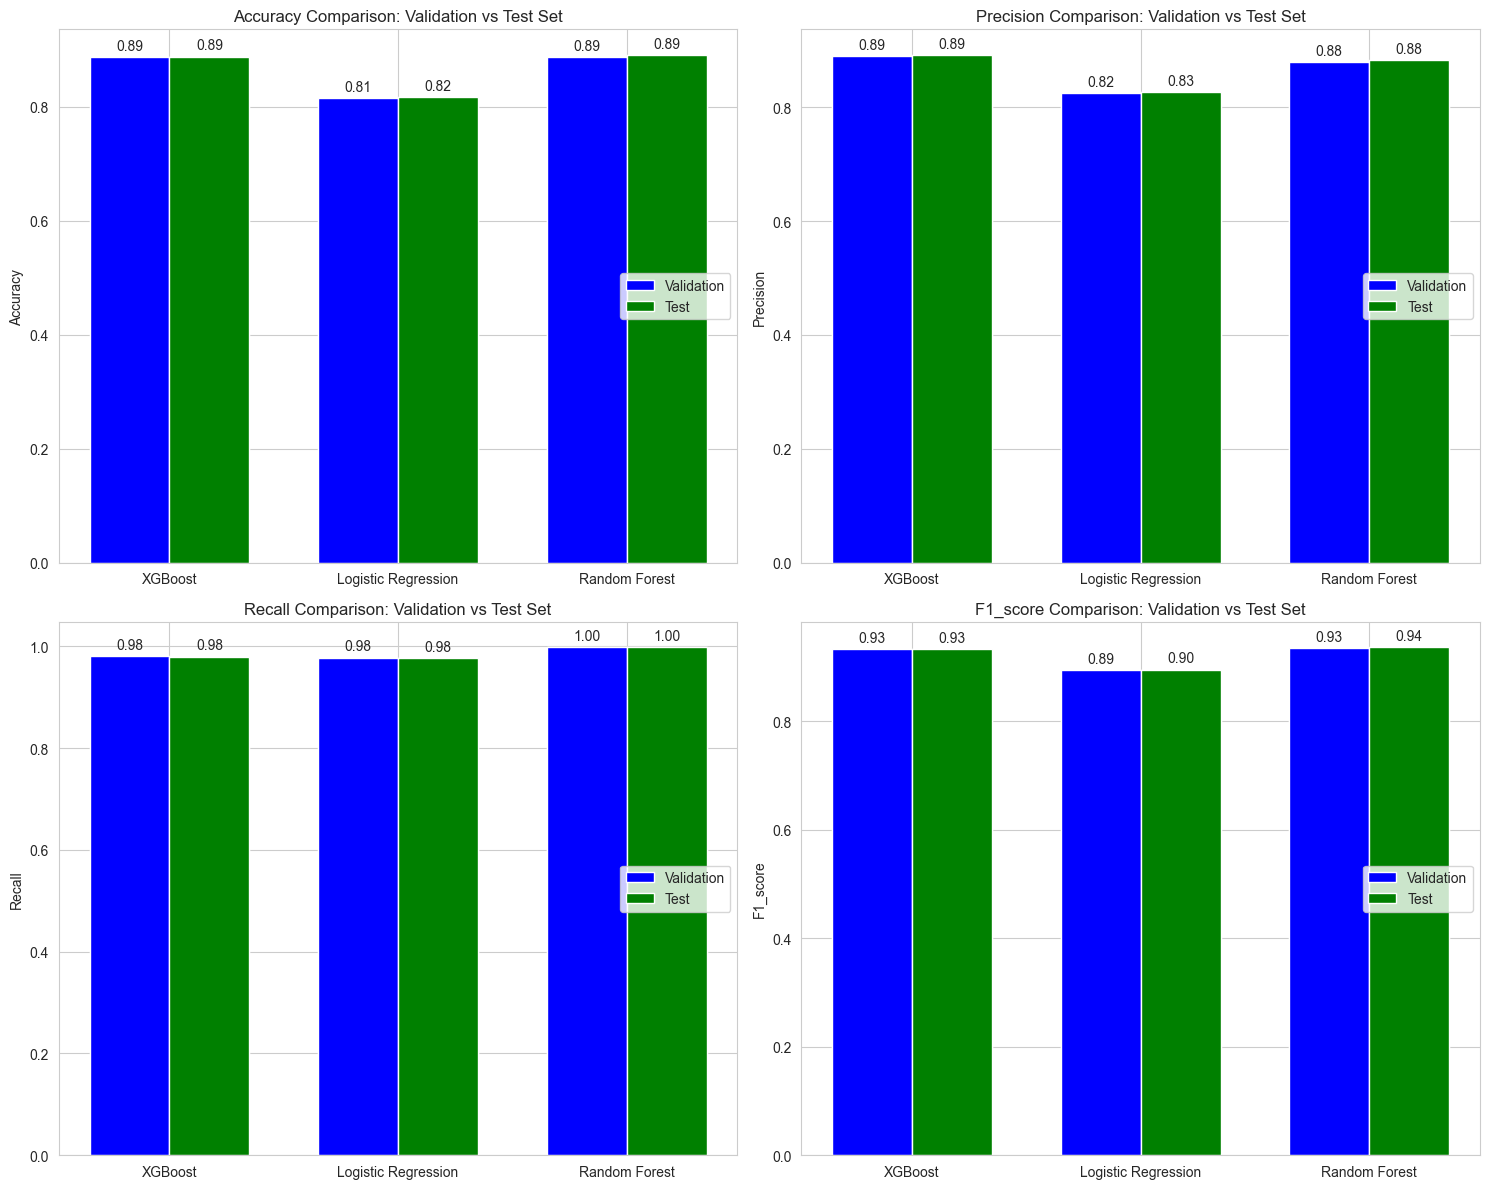

In [85]:
# Plot the metrics
models = list(metrics_dict_val.keys())
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Create 4 subplots (one for each metric) arranged in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

metrics = list(metrics_dict_val[models[0]].keys())  # Metrics names

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    values_val = [metrics_dict_val[model][metric] for model in models]
    values_test = [metrics_dict_test[model][metric] for model in models]

    axs[row, col].bar(x - width / 2, values_val, width, label='Validation', color='b')
    axs[row, col].bar(x + width / 2, values_test, width, label='Test', color='g')

    axs[row, col].set_ylabel(metric.capitalize())
    axs[row, col].set_title(f'{metric.capitalize()} Comparison: Validation vs Test Set')
    axs[row, col].set_xticks(x)
    axs[row, col].set_xticklabels(models)
    axs[row, col].legend(loc='center right')

    # Attach a text label above each bar in rects, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            axs[row, col].annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    autolabel(axs[row, col].bar(x - width / 2, values_val, width, label='Validation', color='b'))
    autolabel(axs[row, col].bar(x + width / 2, values_test, width, label='Test', color='g'))

fig.tight_layout()

plt.show()
